## Castillo Sebastian

## Importamos librerías

In [1]:
import math
import random

import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

#from deap import algorithms
from deap import base  # Estructura que permite agrupar todos los componentes de nuestro algoritmo en una misma bolsa
from deap import creator  # Permite crear los componentes de nuestro algoritmo
from deap import tools  # Contiene funciones precargadas

from joblib import Parallel, delayed

In [2]:
def F(x,y):
    '''
    Función a optimizar.
    '''
    z=-20.0*np.exp(-0.2*np.sqrt(0.5*(x**2+y**2)))-np.exp(0.5*(np.cos(2* np.pi*x)+np.cos(2*np.pi*y)))+np.e+20

    return z

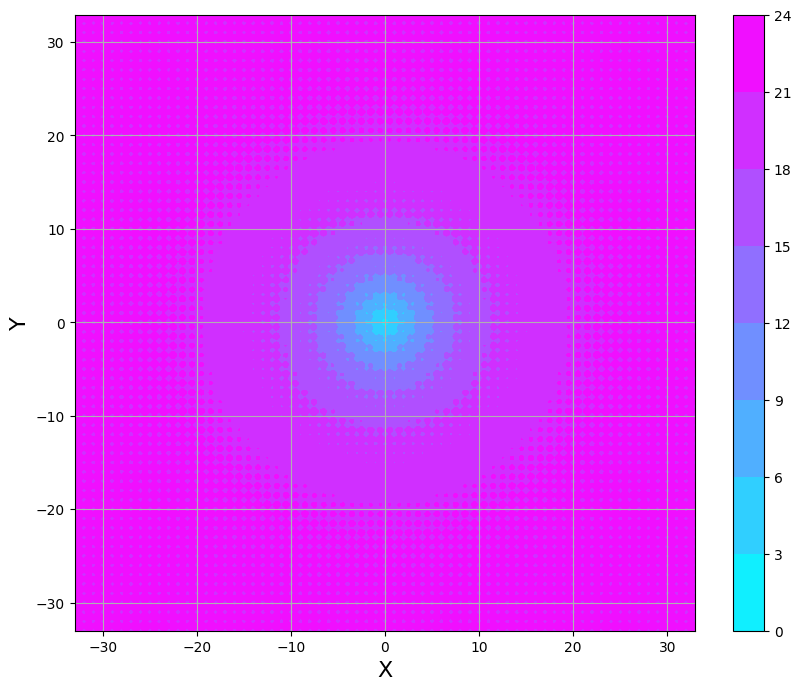

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

V = np.arange(-33, 33, 0.1)

X,Y  = np.meshgrid(V, V)

Z = F(X,Y)

# GRAFICAMOS SUPERFICIE
cs = ax.contourf(X,Y,Z, cmap='cool')

ax.grid(True)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)

fig.colorbar(cs)
plt.show()

In [4]:
len(V)*2

1320

In [5]:
import math
math.ceil(math.log2(1320)) # bits necesarios para represntar el espacio de solución de cada variable

11

Como vemos la función es simple, posee un mínimo global para el rango establecido, sin mímos locales. El algoritmo evolutivo debería resolverlo sin dificultad. Estamos ante un problema estandar de optimización.

## Funciones auxiliares

In [6]:
#=================================
def bin(p=0.5):
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() < p:
        return 1
    else:
        return 0
#=================================


#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    
    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

Implementamos la función de mapeo de genotipo a fenotipo. Conforme al requerimiento representaremos las variables x e y empleando 12 y 24 bits, respectivamente. Para nuestro problema, con un espacio de soluciones de 1322 valores, el empleo de 12 bits por variable *'error:totales (6 por variable)' eso daría 64 y yo estoy trabajando con numeros reales con step 0.1, no enteros* hubiese sido suficiente. Hicimos la funcion de tal forma que tomara como parámetro los valores (en bit) para representar ambas coordenadas del problema.

In [7]:
def bin2dec(ind, low, high, lengths):

    length_x, length_y = lengths
    
    ind_x = ind[:length_x]
    ind_y = ind[length_x:length_x+length_y]

    x = 0
    for k,i in enumerate(ind_x[::-1]):
        x += (i * 2**k)

    x = low + ((high-low)/ ((2**length_x) - 1)) * x

    y = 0
    for k,i in enumerate(ind_y[::-1]):
        y += (i * 2**k)

    y = low + ((high-low)/ ((2**length_y) - 1)) * y

    return x, y

Implementamos la función de fitness provista.

In [8]:
def fitness(ind, low, high):
    '''
    Función de aptitud empleada por nuestro algoritmo.  
      
    '''
    
    dec = bin2dec(ind, low=low, high=high, lengths=(12,24))
    
    z = F(dec[0], dec[1])
    
    return z

## Inicializamos parámetros del experimento

In [9]:
IND_SIZE = 36  # Cantidad total de genes en el cromosoma según requerimiento para representar x e y
LB = -33       # Límite inferior del rango a evaluar
UB = 33        # Límite superior del rango a evaluar

POP_SIZE = 100  # Cantidad de individuos en la población conforme bibliografía y usos
PM = 1./IND_SIZE        # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
N_PARENTS = POP_SIZE - 1 # Número de padres seleccionados para generar la descendencia
PX = 0.9        # Probabilidad de cruza
GMAX = 100      # Cantidad máxima de generaciones que se ejecutará el algoritmo

## Creamos los componentes del algoritmo

In [10]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MINIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(-1.0,)) # Minimización de la función

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness)  # Asignamos un método para evaluar el fitness del individuo

## REGISTRAMOS COMPONENTES

In [11]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin,
                 p=0.5)  # Función asociada a ese componente

#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=5)  # Parámetro que usa el torneo

## Definimos las estadísticas a calcular

In [12]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_size = tools.Statistics(key=len)

# EXTRAEMOS EL TAMAÑO DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               size=stats_size,
                               genes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

In [13]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================

In [14]:
#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
fitnesses = Parallel(n_jobs=6, backend='multiprocessing')(delayed(fitness)(ind, LB, UB) for ind in pop)
#================================================

#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = (fit,)  # Guardamos el fitness para cada individuo (en el individuo)
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

In [15]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmin(fitnesses)  # Si maximizamos, hay que usar ".argmax()"
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values
    #================================================

    
    #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    parents = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #================================================


    #================================================
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for i in range(POP_SIZE//2):
        parent1 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        parent2 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        
        if random.random() < PX:
            childs = toolbox.mate(parent1, parent2)
        else:
            childs = (parent1, parent2)
        
        offspring[2*i] = childs[0]
        offspring[2*i+1] = childs[1]
    #================================================


    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite

    fitnesses = Parallel(n_jobs=6, backend='multiprocessing')(delayed(fitness)(ind, LB, UB) for ind in offspring)
    
    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit,)
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================
    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%10 == 0):
        print('='*79)
        print(f'GENERATION: {g}')
        print(f'ELITE -- Fitness: {elite.fitness.values[0]:.4}')
        print('FITNES: ', records['fitness'])
    #================================================

GENERATION: 10
ELITE -- Fitness: 0.5722
FITNES:  {'avg': 1.2363773729277125, 'std': 0.6934457474019109, 'min': 0.5671581279089928, 'max': 2.512008838665629}
GENERATION: 20
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.5670580268782999}
GENERATION: 30
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.5670580268782999}
GENERATION: 40
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.5670580268782999}
GENERATION: 50
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.5670580268782999}
GENERATION: 60
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.5670580268782999}
GENERATION: 70
ELITE -- Fitness: 0.5671
FITNES:  {'avg': 0.5670580268782999, 'std': 0.0, 'min': 0.5670580268782999, 'max': 0.567

## Graficamos la evolución del fitness

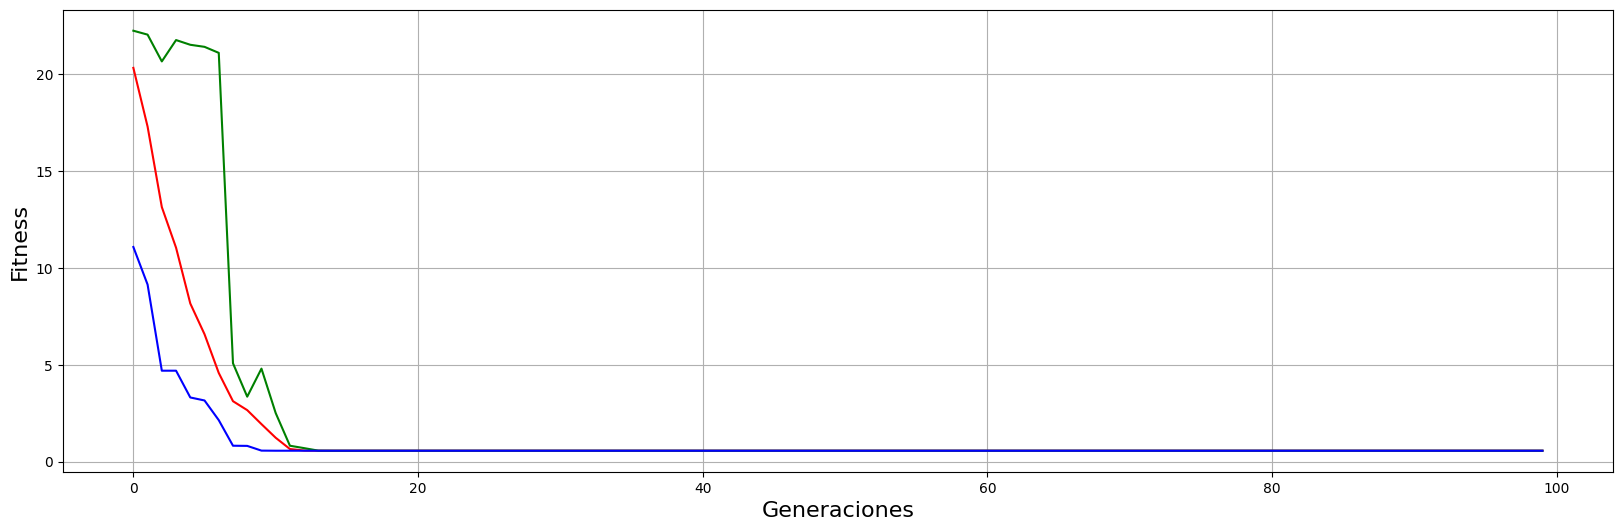

In [16]:
f_avg = [f['avg'] for f in logbook.chapters['fitness']]  # Extraemos fitness promedio a lo largo de las épocas
f_max = [f['max'] for f in logbook.chapters['fitness']]  # Extraemos fitness máximo a lo largo de las épocas
f_min = [f['min'] for f in logbook.chapters['fitness']]  # Extraemos fitness mínimo (elite) a lo largo de las épocas

fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(GMAX), f_avg, '-r')
ax.plot(range(GMAX), f_max, '-g')
ax.plot(range(GMAX), f_min, '-b')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)

Como señalamos al principio el algoritmo rápidamente converge al mínimo de la función en el rango establecido. En el lapso de 10 generaciones encuentra el valor optimo.

In [17]:
x_elit = bin2dec(pop[0],LB,UB, lengths=(12,24))[0]
y_elit = bin2dec(pop[0],LB,UB, lengths=(12,24))[1]
print(x_elit), print(y_elit)

0.10476190476190794
0.009384334646725279


(None, None)

## Graficamos la solución

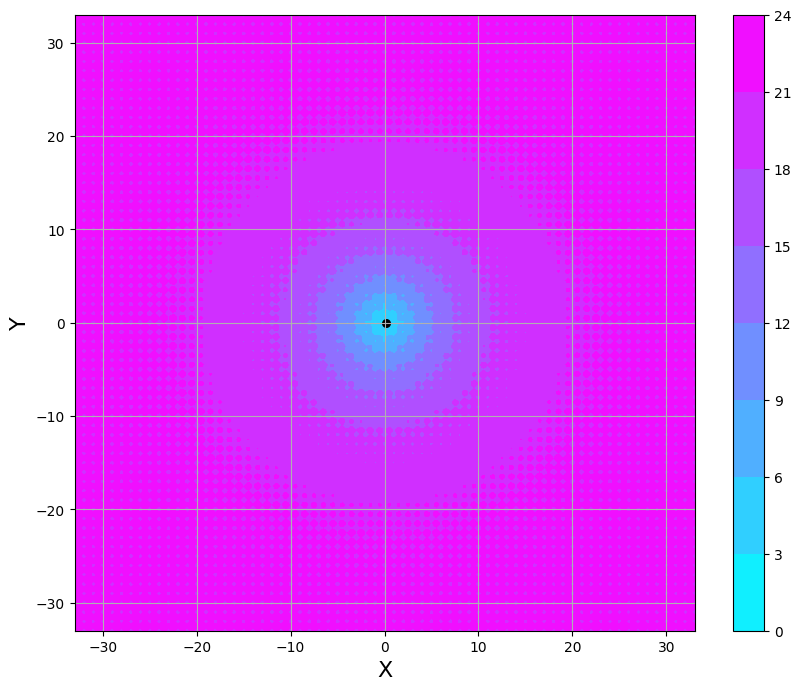

In [18]:
#====================================================
# PLOT RESULTS
#===================
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

delta = 0.1
V = np.arange(LB, UB+delta, delta)

X,Y  = np.meshgrid(V, V)

Z = F(X,Y)

# GRAFICAMOS SUPERFICIE
cs = ax.contourf(X,Y,Z, cmap='cool')

ax.scatter(x_elit, y_elit, s=30, c='k')

ax.grid(True)
ax.set_xlabel('X', fontsize=16)
ax.set_ylabel('Y', fontsize=16)

fig.colorbar(cs)
plt.show()

Aquí podemos ver el individuo elite.